* Автор: Cташ Амир Рамазанович
* Телеграм: svoenravn500

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import optuna
import matplotlib.pyplot as plt

Разработка программных решений — это процесс, сравнимый по сложности с созданием и сборкой самолёта. И, как и любой процесс, даже самый сложный, разработку можно разделить на части.


**Задача** —  разработать алгоритм предсказания количества времени, требующегося на выполнение конкретной задачи на основе исторических данных.

Решения оцениваются по метрике R2 Score.

In [2]:
df_issues_train = pd.read_csv("../input/time-management-data-set/train_issues.csv")
df_emp = pd.read_csv("../input/time-management-data-set/employees.csv")
df_issues_test = pd.read_csv("../input/time-management-data-set/test_issues.csv")

## Генерация и очистка признаков

In [3]:
def baseline_time_feature(df):
    df['created'] = pd.to_datetime(df['created'])
    df['month'] = df.created.dt.month.astype("int8")
    df['day'] = df.created.dt.day.astype('int8')
    df['hour'] = df.created.dt.hour.astype('int8')
    df['minute'] = df.created.dt.minute.astype('int8')
    df['second'] = df.created.dt.second.astype('int8')
    df['year'] = df.created.dt.year.astype("int32")
    df["quarter"] = df.created.dt.quarter.astype("int8")
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    df["month_sin"] = np.sin(df['month'] * (2 * np.pi / 12))
    df["month_cos"] = np.cos(df['month'] * (2 * np.pi / 12))
    df["hour_sin"] = np.sin(df['hour'] * (2 * np.pi / 24))
    df["hour_cos"] = np.cos(df['hour'] * (2 * np.pi / 24))
    df["season_sin"] = np.sin(df['season'] * (2 * np.pi / 12))
    df["season_cos"] = np.cos(df['season'] * (2 * np.pi / 12))
    df["total_days"] =   (df["month"] -4.0)*30 + df["day"] +  df["hour"] /25.0
    df['moment']  = df['created'].dt.hour * 6 + df['created'].dt.minute // 10
    df['hour+minute'] = df['created'].dt.hour * 60 + df['created'].dt.minute
    df['is_afternoon'] = (df['created'].dt.hour > 12).astype('int')
    
    return df

def preproccesing_features(df , df_emp):
    import re
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df = baseline_time_feature(df)
    df = df.drop('created' , axis = 1)
    df = pd.merge(df, df_emp, left_on="assignee_id", right_on="id", how='inner')
    df = df.drop(["full_name","key"],axis = 1)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df

def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\_', '', text)
    return text

def text_features(df, text_cols):
    for cols in text_cols:
        df[text_cols] = df[text_cols].map(lambda x: clean_text(x))
        df['char_count'] = df[text_cols].apply(len)
        df['word_count'] = df[text_cols].apply(lambda x: len(x.split()))
        df['word_density'] = df['char_count'] / (df['word_count']+1)
        df["mean_word_len"] = df[text_cols].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    return df 

def get_stat_features(df,cols):
    df[cols+'_median'] = df[cols].median()
    df[cols+ '_mean'] = df[cols].mean()
    df[cols+ '_std'] = df[cols].std()
    df[cols+ '_max'] = df[cols].max()
    df[cols+ '_min'] = df[cols].min()
    df[cols+ '_zeros_prop'] = (df[cols] == 0).mean()
    return df

def date_text_features(df,cols1,cols2):
    df[cols1 +  ' / ' + cols2] = df[cols1] / df[cols2]
    return df

def groupby_features_id(df,cols):
    df[cols + '_count_id'] = train[['assignee_id' ,cols]].groupby('assignee_id', as_index=False).transform('count')
    return df

def enocode_categorical_features(df, cols):
    encoder = df.groupby(cols).size()/len(df)
    df.loc[:, cols + '_encode'] = df[cols].map(encoder)
    return df

## Преобразование таргета методом Box-cox 

In [4]:
train = preproccesing_features(df_issues_train,df_emp)
test = preproccesing_features(df_issues_test,df_emp)

target_transform = PowerTransformer(method='box-cox')
train['overall_worklogs'] = target_transform.fit_transform(train['overall_worklogs'].values.reshape(-1,1))

## Получение статистических характеристик из временных признаков  

In [5]:
date = ['year' , 'month' , 'day' , 'hour' , 'minute' , 'second' , 'quarter' , 'season']

for cols in date:
    train = get_stat_features(train,cols)
    test = get_stat_features(test,cols)

## Частотное кодирование категориальных признаков 

In [6]:
cat_features = ['position' , 'hiring_type' , 'payment_type' , 'salary_calculation_type' , 'english_level'] 

for cols in cat_features:
    train = enocode_categorical_features(train,cols)
    test = enocode_categorical_features(test,cols)

##  Получение признаков методом группировки с id работника компании

In [7]:
groupby_list = ['position' , 'hiring_type' , 'payment_type' , 'salary_calculation_type' , 'english_level'] 

for cols in groupby_list:
    train = groupby_features_id(train,cols)
    test = groupby_features_id(test,cols)

## Преобразование колонки с описанием задачи  

In [8]:
train = text_features(train,'summary')
test = text_features(test,'summary')

## Получение признаков  day / word_count , hour / word_density

In [9]:
date_list = ['day' , 'hour']
text_list = ['word_count', 'word_density']

for cols1, cols2 in zip(date_list,text_list):
    train = date_text_features(train,cols1,cols2)
    test = date_text_features(test,cols1,cols2)

## Заполнение пропусков 

In [10]:
train = train.fillna(-1)
test = test.fillna(-1)

## TF-IDF Метод для описания задач из Train , Test выборок 

In [11]:
tfidf_vec = TfidfVectorizer(max_features = 5000)
full_tfidf = tfidf_vec.fit_transform(train['summary'].values.tolist() + test['summary'].values.tolist())
train_tfidf = tfidf_vec.transform(train['summary'].values.tolist())
test_tfidf = tfidf_vec.transform(test['summary'].values.tolist())

## Уменьшение размерости значений TF-IDF с помощью SVD   

In [12]:
n_comp = 45
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

## Удаление категориальных и текстовых признаков 

In [13]:
stuff = ["id_x","id_y","overall_worklogs" , "summary" ,'position',
    'payment_type',
    'english_level',
    'hiring_type',
    'salary_calculation_type'
        ]
X = train.drop(stuff,axis = 1)
y = train['overall_worklogs'].values
stuff_test = ["id_x","id_y" , "summary" ,
    'position',
    'payment_type',
    'english_level',
    'hiring_type',
    'salary_calculation_type'
             ]
test = test.drop(stuff_test,axis = 1)

In [25]:
model = CatBoostRegressor(**params_2 , task_type = 'GPU')
model.fit(X_train,y_train, eval_set=(X_test, y_test), verbose=500, use_best_model = True)

0:	learn: 0.9959086	test: 0.9979403	best: 0.9979403 (0)	total: 197ms	remaining: 8m 13s
500:	learn: 0.6909900	test: 0.8948038	best: 0.8947135 (431)	total: 1m 20s	remaining: 5m 20s
1000:	learn: 0.6404736	test: 0.8963629	best: 0.8945634 (506)	total: 2m 38s	remaining: 3m 57s
1500:	learn: 0.6125577	test: 0.8973145	best: 0.8945634 (506)	total: 3m 52s	remaining: 2m 35s
2000:	learn: 0.5889119	test: 0.8973941	best: 0.8945634 (506)	total: 4m 51s	remaining: 1m 12s
2499:	learn: 0.5710592	test: 0.8965369	best: 0.8945634 (506)	total: 5m 49s	remaining: 0us
bestTest = 0.894563409
bestIteration = 506
Shrink model to first 507 iterations.


In [26]:
r2_score(y_test,model.predict(X_test))

0.20091715934344023

In [20]:
!pip install BorutaShap

In [21]:
X_train,X_test , y_train , y_test = train_test_split(X,y , random_state = 512 , shuffle = True)

In [23]:
from BorutaShap import BorutaShap

In [ ]:
model = CatBoostRegressor(**params_2 , task_type = 'GPU')

Feature_Selector = BorutaShap(model = model , importance_measure='shap', classification=False)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=15, random_state=0)

  0%|          | 0/15 [00:00<?, ?it/s]

In [64]:
# def objective(trial):
#     X_train,X_test , y_train , y_test = train_test_split(X , y , random_state = 512 , shuffle = True)
#     param = {
#         'verbose' : False,
#         'task_type' : 'GPU',
#         'random_strength' : trial.suggest_float('random_strength', 0.2 ,1),
#         'bagging_temperature' : trial.suggest_loguniform('bagging_temperature' , 1e-1 , 1),
#         "iterations": trial.suggest_int("iterations", 1500,  8500 , 500),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'max_bin': trial.suggest_int('max_bin', 200, 400),
#     }
    
#     model = CatBoostRegressor(**param)
#     model.fit(X_train,
#             y_train,
#             eval_set=[(X_test, y_test)],
#             use_best_model = True,
#         )
#     r2 = r2_score(y_test,model.predict(X_test))
    
#     return r2

In [65]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

[I 2022-09-19 13:30:36,164] A new study created in memory with name: no-name-1fef30a1-86b4-4f26-b7f1-e7e7ca2c87d1
[I 2022-09-19 13:33:05,090] Trial 0 finished with value: 0.20458370553190386 and parameters: {'random_strength': 0.8197048758546319, 'bagging_temperature': 0.30455327281789984, 'iterations': 7500, 'learning_rate': 0.08784935695694263, 'max_depth': 6, 'l2_leaf_reg': 0.12896445448792274, 'max_bin': 316}. Best is trial 0 with value: 0.20458370553190386.
[I 2022-09-19 13:39:29,559] Trial 1 finished with value: 0.22032340358705593 and parameters: {'random_strength': 0.6181745811484893, 'bagging_temperature': 0.39790153772134507, 'iterations': 2500, 'learning_rate': 0.03001889082007212, 'max_depth': 11, 'l2_leaf_reg': 0.21405218553702227, 'max_bin': 230}. Best is trial 1 with value: 0.22032340358705593.
[I 2022-09-19 13:56:49,224] Trial 2 finished with value: 0.2076558417231451 and parameters: {'random_strength': 0.557162609717007, 'bagging_temperature': 0.1386809263770947, 'iter

KeyboardInterrupt: 

### Использовался для решения Catboost с подбором гиперпараметров (Optuna)

In [14]:
params_2 = {'random_strength': 0.6181745811484893,
            'bagging_temperature': 0.39790153772134507, 
            'iterations': 2500,
            'learning_rate': 0.03001889082007212,
            'max_depth': 11,
            'l2_leaf_reg': 0.21405218553702227,
            'max_bin': 230}

In [49]:
best_params = {'l2_leaf_reg': 0.002522570649850132,
 'max_bin': 233,
 'n_estimators': 2800,
 'max_depth': 9,
 'min_data_in_leaf': 148}

### Параметры валидации, обучение будет идти на kFold_random_state * n_splits фолдах

#### Для обучения рекомендуется использовать GPU

In [15]:
models_cat = []
n_splits = 5
kFold_random_state = [101, 42, 666, 228, 777, 2021,]# 75 , 869 ,1370 , 1750, 2142 ,3657]
N = len(kFold_random_state)*n_splits

for ind_k, random_state in enumerate(kFold_random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = CatBoostRegressor(**params_2 , task_type = 'GPU' , random_seed= random_state , early_stopping_rounds= 250 + ind_k*10)
        model.fit(X_train, y_train, eval_set=(X_test, y_test),
                verbose=500, use_best_model = True, plot=False)
        r2 = r2_score(y_test, model.predict(X_test))
        print(r2)
        models_cat.append(model)

assert len(models_cat) == N

0:	learn: 0.9963095	test: 0.9953350	best: 0.9953350 (0)	total: 220ms	remaining: 9m 9s
500:	learn: 0.7134664	test: 0.8914851	best: 0.8914276 (478)	total: 1m 17s	remaining: 5m 9s
1000:	learn: 0.6342651	test: 0.8897361	best: 0.8894994 (974)	total: 2m 35s	remaining: 3m 52s
1500:	learn: 0.5906792	test: 0.8886093	best: 0.8879690 (1401)	total: 3m 58s	remaining: 2m 39s
bestTest = 0.8879689586
bestIteration = 1401
Shrink model to first 1402 iterations.
0.20852164846652343
0:	learn: 0.9994558	test: 0.9818651	best: 0.9818651 (0)	total: 192ms	remaining: 7m 59s
500:	learn: 0.6981473	test: 0.8744779	best: 0.8742601 (480)	total: 1m 25s	remaining: 5m 41s
bestTest = 0.8734071446
bestIteration = 628
Shrink model to first 629 iterations.
0.2133591392749531
0:	learn: 0.9943123	test: 1.0030132	best: 1.0030132 (0)	total: 191ms	remaining: 7m 57s
500:	learn: 0.6969748	test: 0.8963425	best: 0.8962958 (484)	total: 1m 23s	remaining: 5m 34s
bestTest = 0.8960335082
bestIteration = 743
Shrink model to first 744 ite

### Усреднение полученных предсказаний моделей

In [16]:
y_pred = np.zeros((len(test),))
scores = []
for model in models_cat:
    y_pred += model.predict(test)

y_pred /= N

In [19]:
len(models_cat)

60

In [17]:
y_pred

array([0.10313975, 0.05787163, 0.14571944, ..., 0.76977492, 0.47052483,
       0.06943113])

### Топ 20 признаков 

Всего признаков 136 Усреднее по 60-ти моделям: 
На график нанесено топ-20 признаков


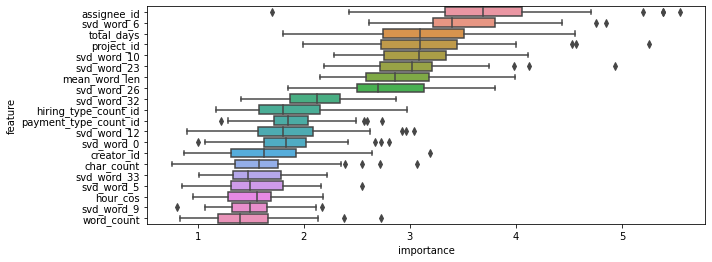

In [18]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(X, models_cat, 0.20, top_n=20)

### Предсказания  на Test выборке

In [20]:
submission = pd.read_csv('../input/time-management-data-set/sample_solution.csv')

In [21]:
submission['overall_worklogs'] = y_pred

### Обратное преобразование таргета и округления наших предсказаний

In [22]:
submission['overall_worklogs'] = target_transform.inverse_transform(submission['overall_worklogs'].values.reshape(-1,1))
submission['overall_worklogs'] = submission['overall_worklogs'].round().astype(int)

In [23]:
submission

,id,overall_worklogs
0,675975,7403
1,675972,6999
2,675965,7805
3,675961,10238
4,675955,8406
...,...,...
1065,702545,15787
1066,702528,13607
1067,702499,17161
1068,702376,11726


In [24]:
submission.to_csv('catboost_60_models_tuning.csv', index = False)